# Clustering 
In this module we will use discrete optimization for clustering of points scattered in a two dimensional euclidean space.

Let's put together a function to generate points.

In [3]:
import numpy as np

def generate_points(centers, counts, scales):
    """Generate points in a two-dimensional space
    
    Args:
        centers: list of pairs
        counts: list of number of points in each cluster
        scales: standard deviation of points from each center
        
    Returns:
        points: list of points (with size equal to the sum of counts)
    
    """
    centers = np.array(centers)
    points = np.zeros([sum(counts), 2])
    start = 0
    for center, count, scale in zip(centers, counts, scales):
        points[start:start + count] = center + np.random.normal(0, scale, size=[count, 2])
        start += count
    return points

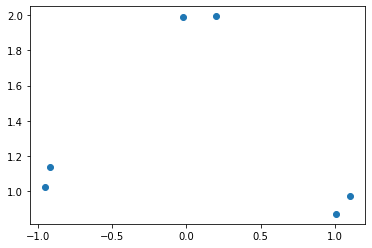

In [6]:
# three clusters with 2 points each
counts = [2, 2, 2]

num_points = sum(counts)
num_clusters = len(counts)

points = generate_points([(-1, 1), (1, 1), (0, 2)], counts, [0.1, 0.1, 0.1])

# pairwise distance of each pair of points
distances = {(i, j): np.sqrt(np.sum(np.square(points[i] - points[j])))
            for i in range(num_points)
            for j in range(num_points)
            if i != j
            }

one_hot_penalty = 10

import matplotlib.pyplot as plt
plt.scatter(*zip(*points))

# Create BQM object

Create the BQM object
- decision variables: xij = 1 if the point i is assigned to the cluster j otherwise 0
- total number of variables: number of points times number of clusters
- there is no initial linear bias since all assigments are equal


In [33]:
from dimod import AdjVectorBQM

bqm = AdjVectorBQM('BINARY')

x = {(i, j): bqm.add_variable((f'x_{i}', j), 0)
     for i in range(num_points)
     for j in range(num_clusters)
     }

- pairwise penalty exist between every pair of points if they belong to the same cluster (otherwise no penalty and no reward)
- the penalty is proportional (or equal) to the distance

In [34]:
from itertools import combinations

for i, j in combinations(range(num_points), r=2):
    for k in range(num_clusters):
        bqm.add_interaction(x[i, k], x[j, k], distances[i, j])

# Add constraint
- Each point can only be assigned to one cluster
- The sum of xij for all values of j (all possible clusters) amounts to one

In [35]:
for i in range(num_points):
    bqm.add_linear_equality_constraint(
        [(x[i, k], 1.0) for k in range(num_clusters)],
        constant=-1.0,
        lagrange_multiplier=one_hot_penalty
    )

# Result

In [36]:
from neal import SimulatedAnnealingSampler

response = SimulatedAnnealingSampler().sample(bqm, num_reads=100, num_sweeps=10000).truncate(3)
print(response)

  ('x_0', 0) ('x_0', 1) ('x_0', 2) ('x_1', 0) ... ('x_5', 2)   energy num_oc.
0          0          1          0          0 ...          1 0.477401       1
1          0          1          0          0 ...          1 0.477401       1
2          0          1          0          0 ...          1 0.477401       1
['BINARY', 3 rows, 3 samples, 18 variables]


In [38]:
best_solution = response.first.sample
assignments = {point: cluster for (point, cluster), value in best_solution.items() if value}

print(assignments)

{'x_0': 1, 'x_1': 1, 'x_2': 0, 'x_3': 0, 'x_4': 2, 'x_5': 2}
